<a href="https://colab.research.google.com/github/JR-1991/Catalax/blob/master/examples/MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import catalax
except ImportError:
    !pip install git+https://github.com/JR-1991/Catalax.git

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from catalax import Model, visualize
from catalax.mcmc import run_mcmc, plot_corner

jax.config.update("jax_enable_x64", True)

In [14]:
# Initialize the model
model = Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

model

Model summary


Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[K_m, v_max]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None


In [4]:
# Generate irregular time series data
# from a simple menten model

# Data is sampled at different time points
# and also not at zero to reflect realistic
# scenarios
time = jnp.array([
    [10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 130],
])

# Set initial conditions above and below the 
# true Km value for the sake of the example
initial_conditions = [
    {"s1": 300.0},
    {"s1": 200.0},
    {"s1": 80.0},
    {"s1": 50.0},
]

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1, saveat=time, in_axes=(0, None, 0)
)

# Add some noise for realism
data = np.random.normal(data, 1.0).clip(min=0)
# data = np.random.normal(data, 15.0).clip(min=0) # Uncomment to add more noise

print(f"Time: {time.shape} | Data: {data.shape}")

Time: (4, 6) | Data: (4, 6, 1)


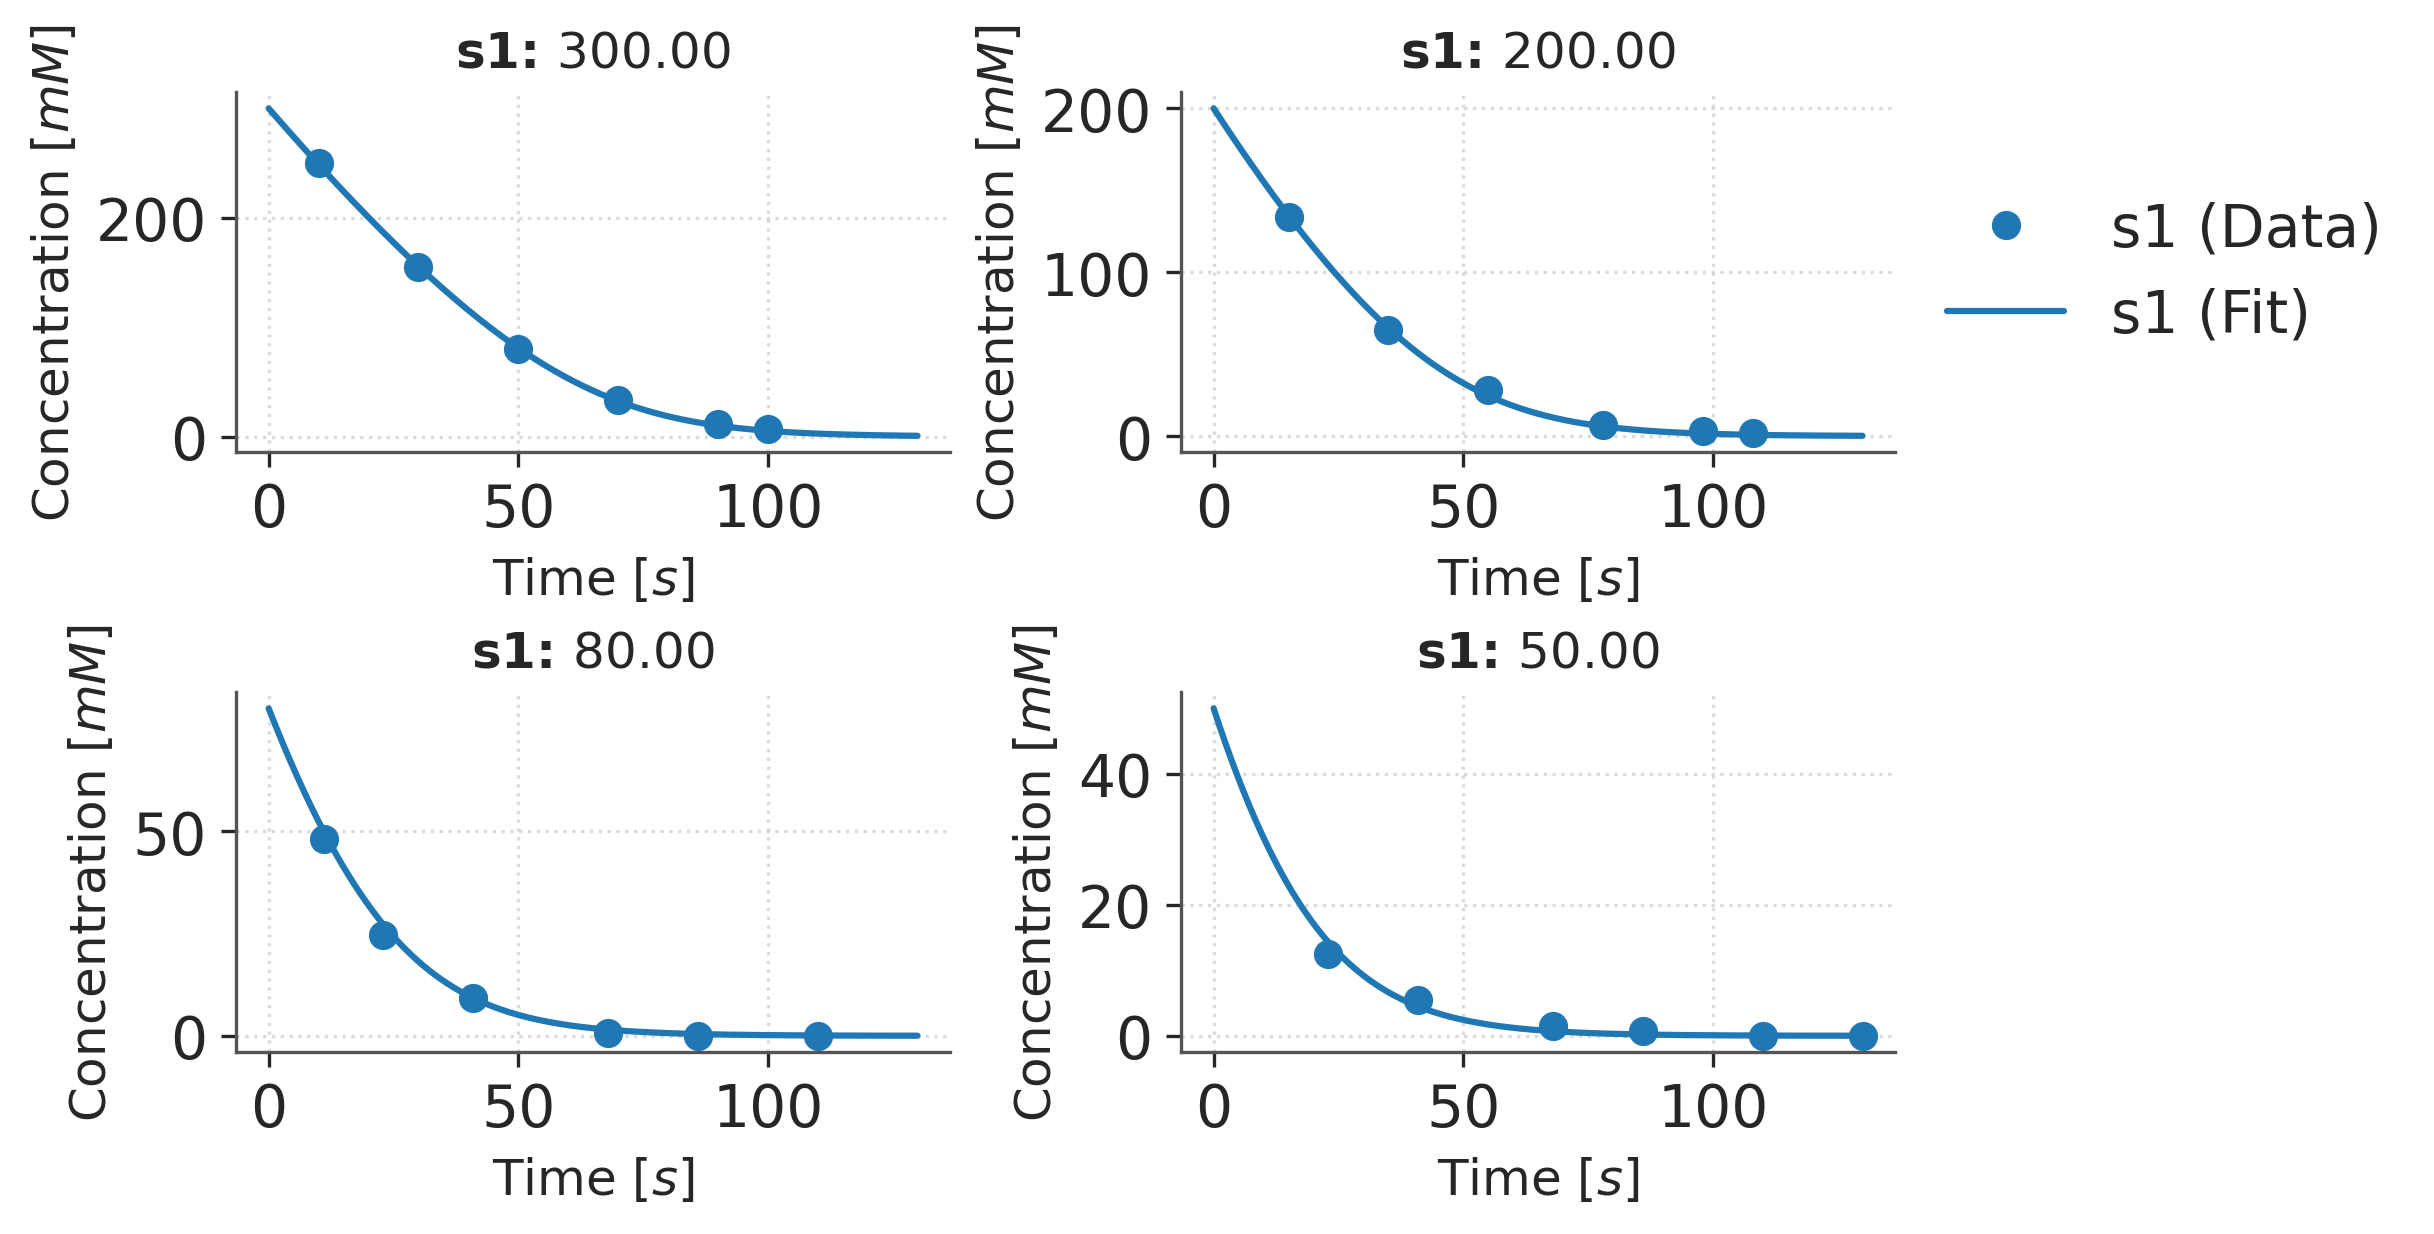

In [5]:
f = visualize(
    model=model,
    data=data,
    times=time,
    initial_conditions=initial_conditions,
    figsize=(4,2),
)

In [6]:
from catalax.mcmc import priors

# Define Priors
model.parameters.v_max.prior = priors.Uniform(low=1e-6, high=200.0)
model.parameters.K_m.prior = priors.Uniform(low=1e-6, high=1e3)

model.parameters.v_max.prior

Uniform(type='Uniform', low=1e-06, high=200.0)

In [7]:
# Perform MCMC simulation
mcmc, bayes_model = run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=1000,
    num_samples=1000,
    dt0=0.1,
    max_steps=64**4
)

<<< Priors >>>

K_m: U(low=1e-06, high=1000.0)
v_max: U(low=1e-06, high=200.0)

<<< Running MCMC >>>



sample: 100%|██████████| 2000/2000 [00:25<00:00, 78.33it/s, 3 steps of size 7.44e-01. acc. prob=0.88]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m    104.13      5.20    104.09     95.60    112.45    695.44      1.00
     sigma      1.40      0.22      1.36      1.05      1.75    539.41      1.00
     v_max      7.13      0.15      7.12      6.87      7.38    712.21      1.00

Number of divergences: 0


In [15]:
# Add parameters to the model
for param, samples in mcmc.get_samples().items():
    if param not in model.parameters:
        continue
    
    model.parameters[param].value = float(samples.mean())
    
model.parameters

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,104.129364,False,None,None,None,None
1,v_max,v_max,7.126747,False,None,None,None,None


/Users/jara1991/anaconda3/envs/jaxlibnew/lib/python3.10/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/Users/jara1991/sysbiojax/catalax/mcmc/plotting.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


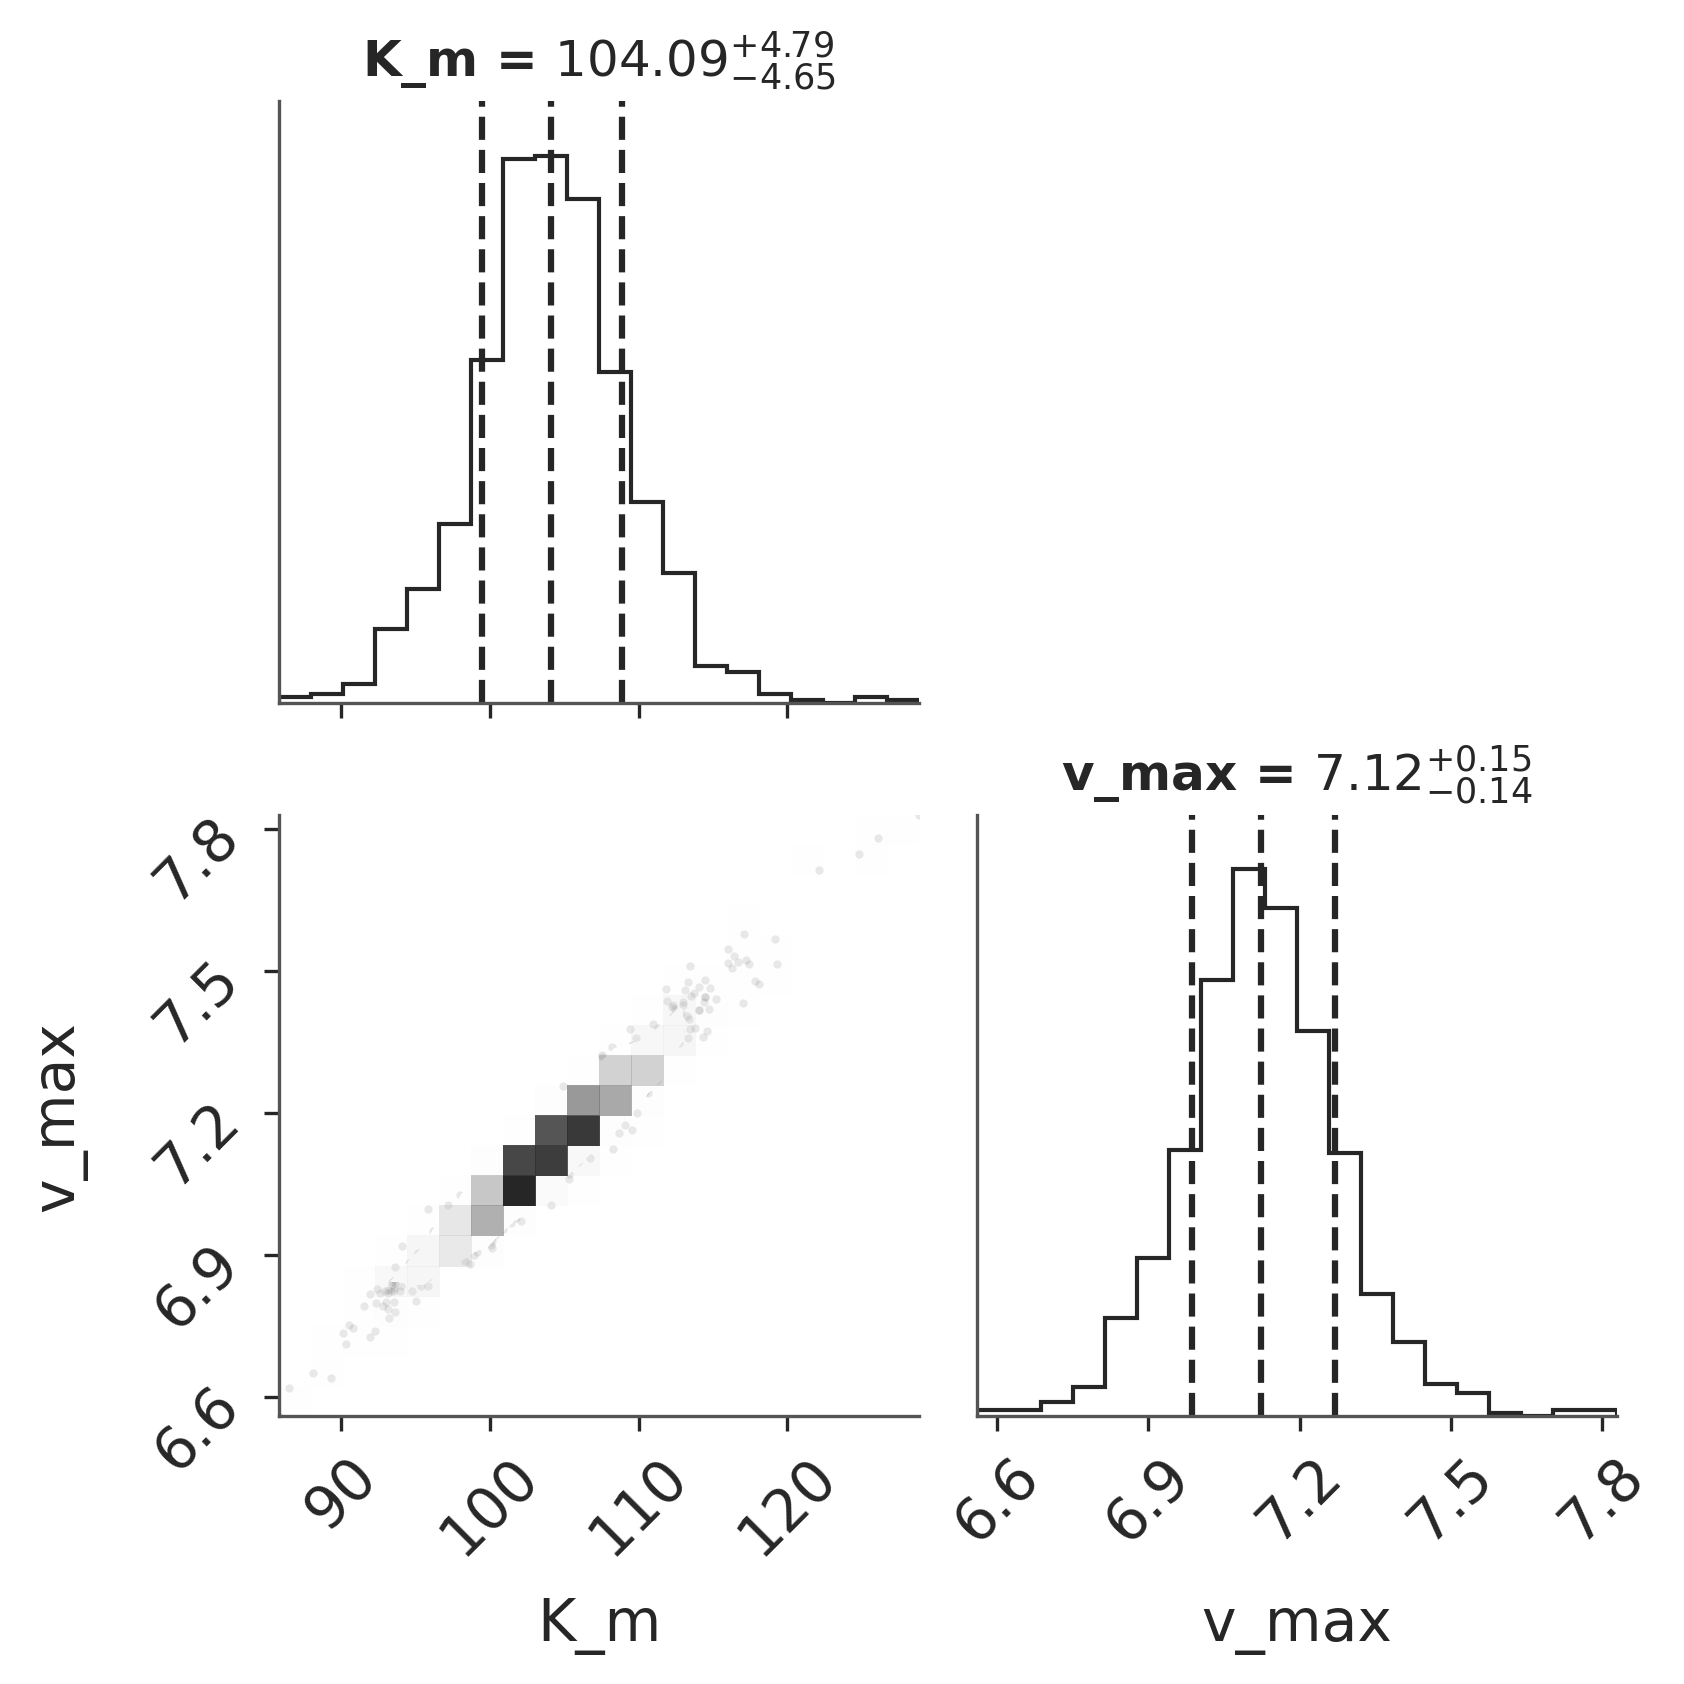

In [9]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = plot_corner(mcmc)

/Users/jara1991/sysbiojax/catalax/mcmc/plotting.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


array([[<Axes: title={'center': 'K_m'}>, <Axes: title={'center': 'K_m'}>],
       [<Axes: title={'center': 'v_max'}>,
        <Axes: title={'center': 'v_max'}>]], dtype=object)

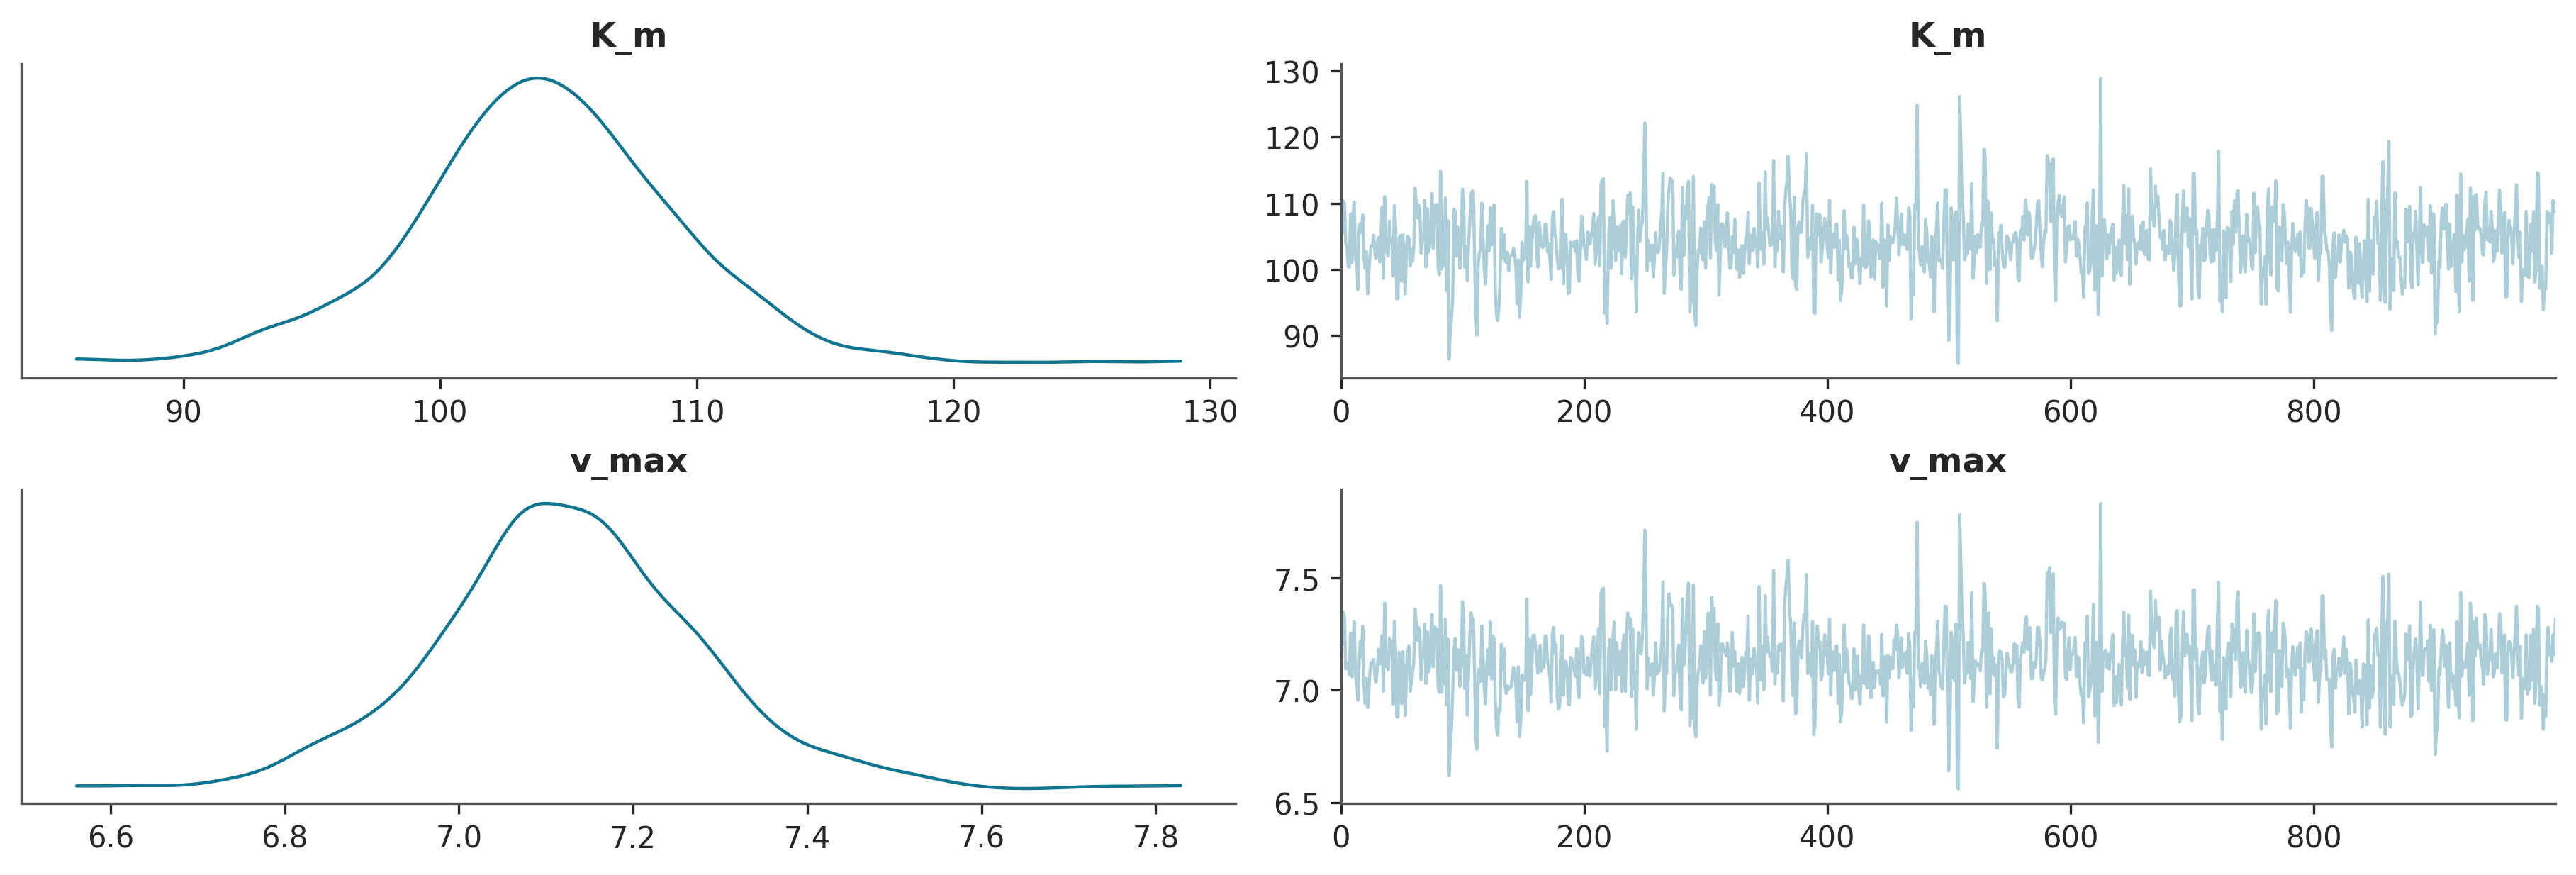

In [10]:
from catalax.mcmc import plot_trace

# Plot the trace of the MCMC (Posterior dist and chain trace)
plot_trace(mcmc, model)

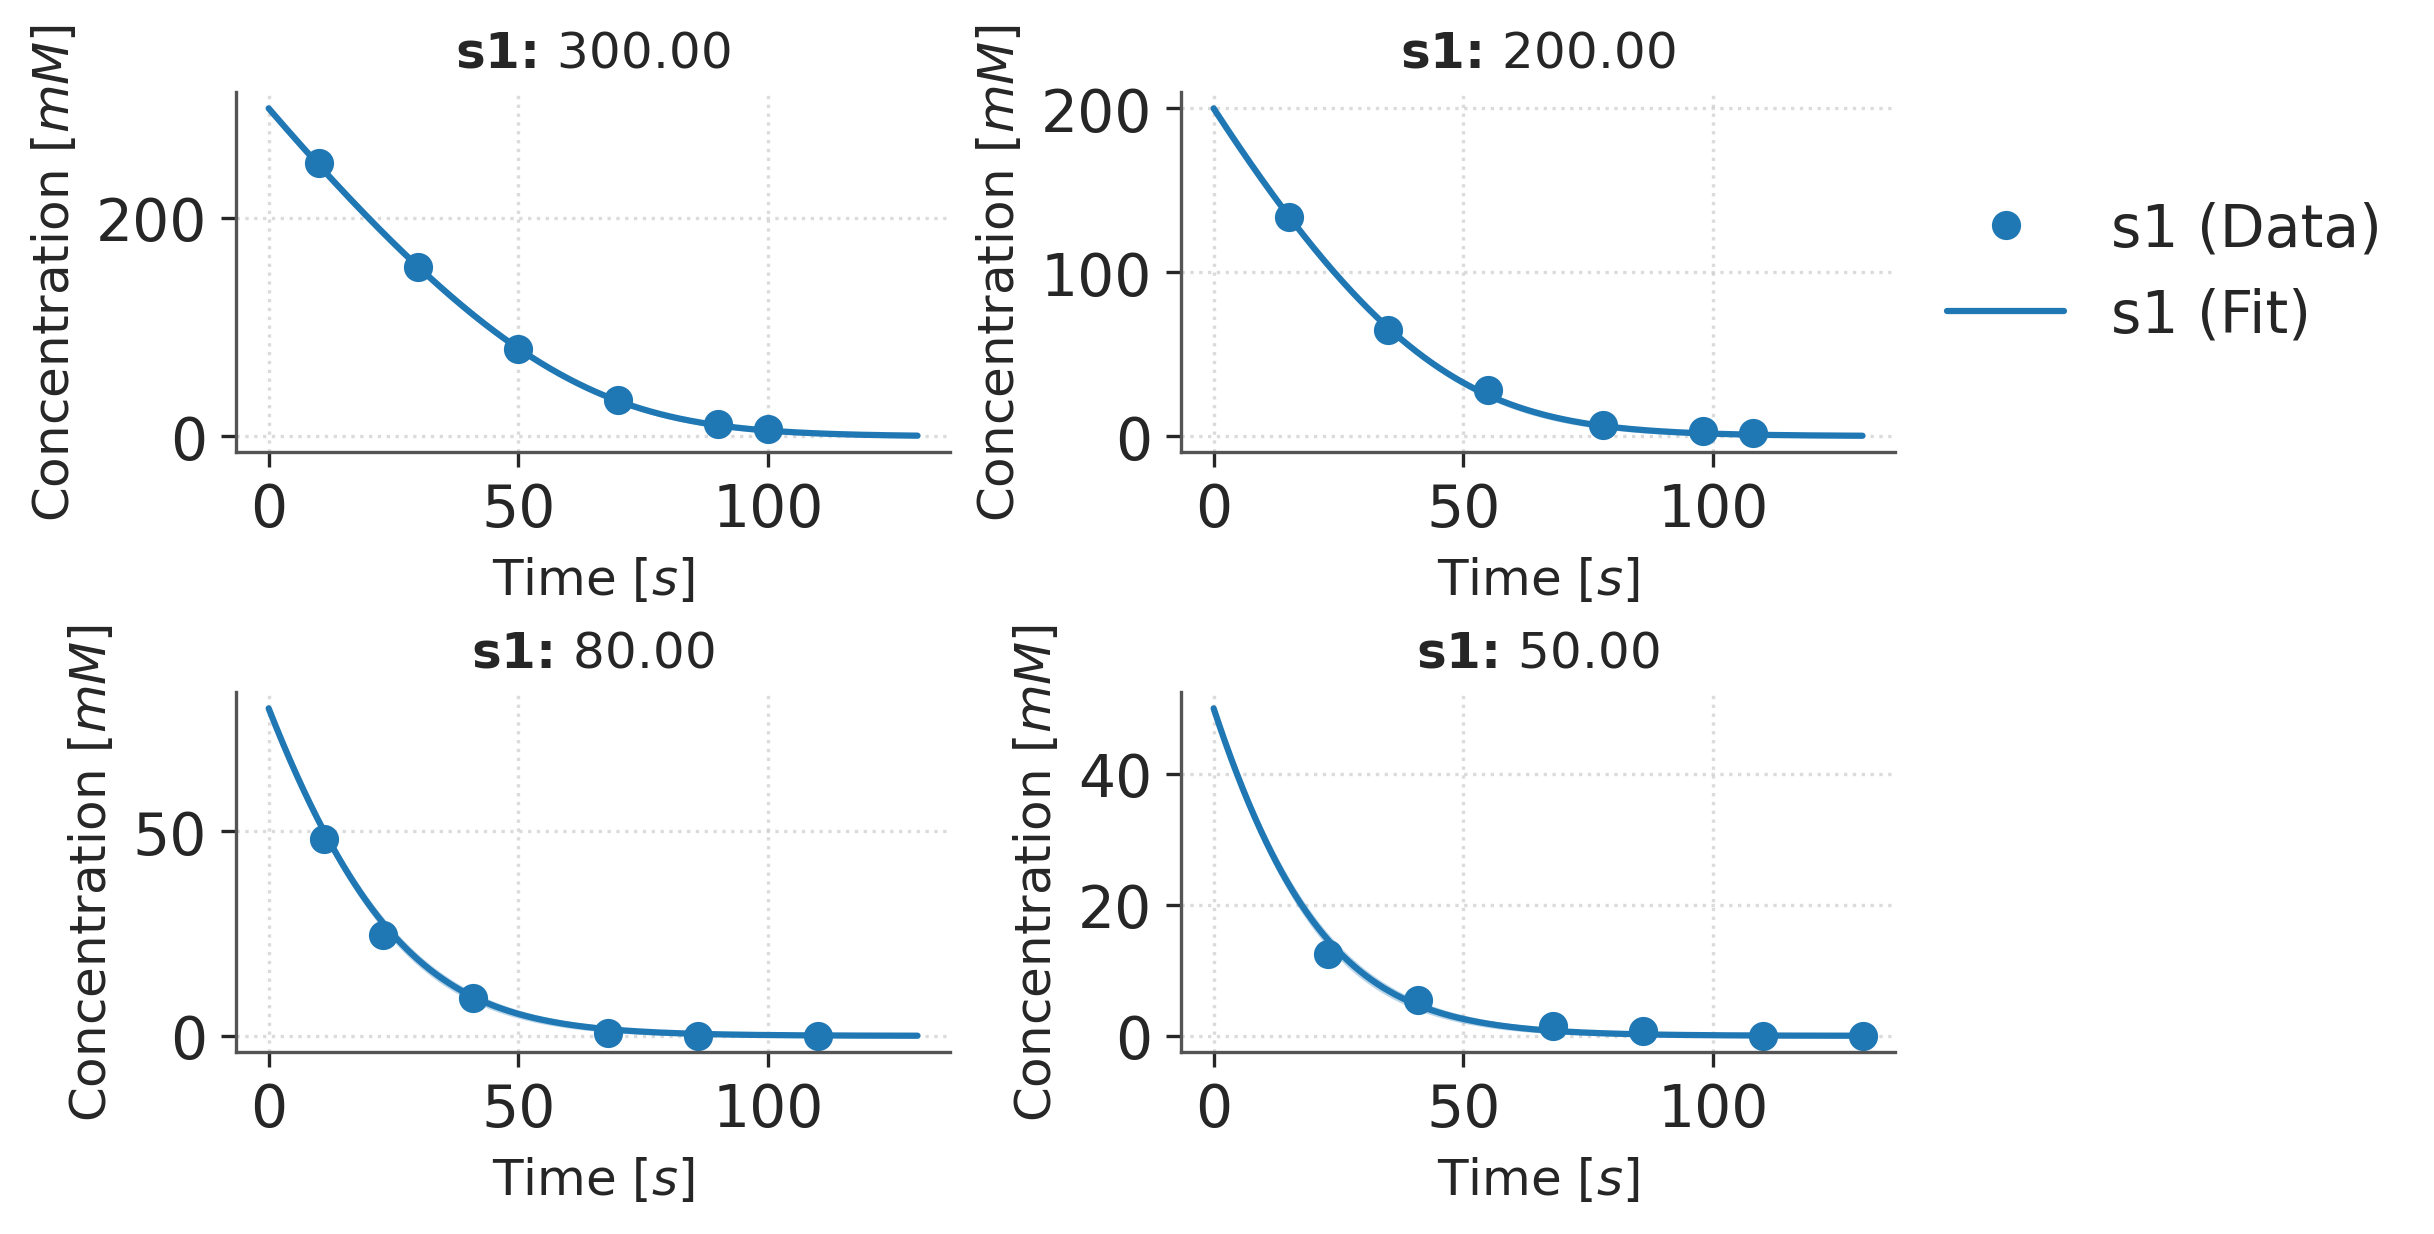

In [16]:
# Visualize fit of MCMC to data
#
# When an mcmc object is passed to visualize, the fit is plotted
# including the 90% highest posterior density interval (HPDI) of
# the parameters and thus the uncertainty of the fit.
#
# In order to see the effects, change the line in the beginning
# to the following:
#       
#      data = np.random.normal(data, 15.0).clip(min=0)
#
# This will add some noise to the data and the fit will be less
# certain and the HPDI will be wider.

f = visualize(
    model=model,
    data=data,
    times=time,
    initial_conditions=initial_conditions,
    figsize=(4,2),
    mcmc=mcmc
)